In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd /content/gdrive/My\ Drive/Accident_Anticipation/depth_estimation/google_distance_code/google-research/depth_from_video_in_the_wild
from image_utils import *

%cd /content/gdrive/My\ Drive/Accident_Anticipation/depth_estimation/google_distance_code/google-research

# %cd /content/gdrive/My\ Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/google_dist_code_1/google-research
#%cd /content/gdrive/My\ Drive/Accident_Anticipation/Anticipating-Accidents/dataset/videos/frames/

!pip install tensorflow-graphics

from __future__ import absolute_import, division, print_function

from absl import logging
import os
import image_utils
import cv2

import re
import time
import glob
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

from PIL import Image

import tensorflow as tf
from depth_from_video_in_the_wild import model_3

# https://github.com/google-research/google-research/tree/master/depth_from_video_in_the_wild

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········


In [0]:
# (1): Verify updated bounding box locations
# cropped images location 
cropped_img_path = '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/google_distance_code/accident_data/reformatting_imgs/reordered_final_outputs_2/'

# path to optimal crops
# optimal_crop_path = '/content/gdrive/My Drive/Accident_Anticipation/Anticipating-Accidents/preprocessed_features/optimal_crops_det/' # shows the crops done for each image
optimal_crop_path = '/content/gdrive/My Drive/Accident_Anticipation/Anticipating-Accidents/preprocessed_features/optimal_crops_SORT_det/' 
optimal_crop_path = '/content/gdrive/My Drive/Accident_Anticipation/Anticipating-Accidents/preprocessed_features/optimal_crops_det_2/' 

# path to depth_from_the_wild outputs
path_odom = '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/google_distance_code/google-research/depth_from_video_in_the_wild/odometry_trajectory_outputs_2/'
path_depth = '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/depth_maps/distance_maps_trained_1/'


root = '/content/gdrive/My Drive/Accident_Anticipation/Anticipating-Accidents'
# path
train_path = root + '/dataset/features/training/' 
test_path = root +  '/dataset/features/testing/' 

save_path = '/content/gdrive/My Drive/Accident_Anticipation/EXTRACT_PHYSICS_NOTEBOOKS/physical_features/5_world_coordinates_5/'

training_path = '/content/gdrive/My Drive/Accident_Anticipation/Anticipating-Accidents/dataset/features/training-sort/output_sort9AGE=2IOU=0.3/'
testing_path = '/content/gdrive/My Drive/Accident_Anticipation/Anticipating-Accidents/dataset/features/testing-sort/output_sort10AGE=2IOU=0.3/'

# OUTPUT_DIR = '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/accident_data/reformatting_imgs/reordered_final_outputs_2/'

Determing the accuracy of the bounding boxes

In [0]:
# batch_str = 'batch_005.npz'
# mode = 'training'
# vid_num = 2

num1 = (126, 46)
modes = ('training', 'testing')
adding_indices_bool = True
mode_paths = (train_path, test_path)
#@
feat_ind = (training_path, testing_path)

# depth_np = np.load(depth_complete_paths[vid_num]) # ['distance_map']
# odom_np = np.load(odom_complete_paths[vid_num]) # ['rot', 'trans', 'instrinsic_matrix', 'orientation', 'position']

for mode_iter in range(2):
  num_batches = num1[mode_iter]
  mode = modes[mode_iter]

  cur_path = optimal_crop_path+'/'+mode+'/'

  for batch_iter in range(num_batches):
    batch_str = 'batch_%03d.npz'%(batch_iter+1)
    if batch_iter % 15 == 0:
      print(batch_str)

    # cropped_dict = np.load(cur_path+batch_str)
    org_bb = np.load(mode_paths[mode_iter]+batch_str) # use org_bb to retrieve bounding boxes, and the correct video ID
    resized_bb = np.load(cur_path+batch_str) # use org_bb to retrieve bounding boxes, and the correct video ID

    #@@ Add dimension (-2), representing the feature_indices
    feat_indices = np.load(feat_ind[mode_iter]+batch_str)['sortdet']
    print(feat_indices[2,5,:,-1])
    print(feat_indices[2,5,:,-2])

    if adding_indices_bool:
      resized_bb1 = np.zeros((resized_bb['new_det'].shape[0],resized_bb['new_det'].shape[1], resized_bb['new_det'].shape[2], resized_bb['new_det'].shape[3]+1))
      resized_bb1[:,:,:,0:5] = resized_bb['new_det'][:,:,:,0:5]
      resized_bb1[:,:,:,5] = feat_indices[:, :, :, -2]
      resized_bb1[:,:,:,6::] = resized_bb['new_det'][:,:,:,5::] 

    bounding_box = np.load(optimal_crop_path+mode+'/'+batch_str)
    frame_paths, frame_labels = retrieve_dir1(org_bb['labels'], org_bb['ID'],mode, num1[mode_iter])
    odom_paths = retrieve_dir_custom(path_odom, org_bb, mode, num1[mode_iter], split_type=1)
    depth_paths = retrieve_dir_custom(path_depth, org_bb, mode, num1[mode_iter])
    for vid in range(10):
      cur_name = re.split('/',depth_paths[vid])[-1][0:-4]
      if os.path.exists(save_path+cur_name+".pkl"):
      # if False:
        pass
      else:
        trajectory_df = obtain_trajectory_data(resized_bb1, depth_paths, odom_paths, vid,dist_coeff = 8*10**(-7),intr_type = 'med', num_frames = 99)
        trajectory_df.to_pickle(save_path+cur_name+".pkl")
        print(save_path+cur_name+".pkl")
        # negative/positive_##

    #! Save trajectory_df
    #! file_name1 = '%03d' %car_vid_batch

In [0]:
trajectory_df.head()

,TIMESTAMPS,X,Y,Z,b0,b1,b2,b3,Feat_Index,Object_Type,Agent_ID
0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.000000,0.316030,0.155937,0.520004,316.5,92.0,337.5,123.0,0.0,4.0,1.0
0,0.050505,-0.000001,-0.000002,0.000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,0.050505,0.314538,0.131464,0.420636,341.5,90.0,371.5,128.0,0.0,4.0,1.0
1,0.050505,-0.213459,0.097833,0.473853,72.5,91.0,92.5,102.0,1.0,4.0,2.0


## Converting 2D points to 3D world coordinates

In [0]:
## function that retrieve u,v for agent
## function that retrieves Z for each agent
## solve for X and Y
# look at "transform_depth_map.py"

# print(odom_complete_paths)
# odom_np = np.load(odom_complete_paths[vid_num]) # ['rot', 'trans', 'instrinsic_matrix', 'orientation', 'position']
# print(odom_np['instrinsic_matrix'].shape)
# int_mat = np.mean(odom_np['instrinsic_matrix'], axis = 0)
# print(int_mat)

def _retrieve_pixels(det, depth_map): # 
  ## if we are taking centers, Can take alternate function that uses features extractor to follow the same point along a car
  U = np.round((det[:,1] + det[:,3])/2) 
  V = np.round((det[:,0] + det[:,2])/2)

  # remove the out of bounds points
  U[U>=128]= 127
  V[V>=416]= 415

  Z = np.zeros(det.shape[0])
  for k in range(len(Z)):
    Z[k] = depth_map[int(U[k]), int(V[k])]
  return U, V, Z

def _2D_to_3D_coordinates(int_mat, Z, U, V):
  f_u, f_v, c_u, c_v = int_mat[0,0], int_mat[1,1], int_mat[0,-1], int_mat[1,-1]
  X, Y = np.multiply(Z,(U -c_u))/f_u, np.multiply(Z,(V-c_v))/f_v
  ## add option to apply quadratic radial distortion
  return X, Y

def _rigid_transformation(rot, trans, P_camera):
  D = np.eye(4)
  D[0:3,0:3], D[0:3, -1] = rot, trans
  return D.dot(P_camera)

# function that obtains trajectory data, in the form of a pandas dataframe
def obtain_trajectory_data(cropped_dict, depth_path, odom_path, vid,dist_coeff = 0.0,intr_type = 'med', num_frames = 99):
  #(0): create pandas object
  df = pd.DataFrame({})
  ## initialize empty dataframe, and append dictionary each iteration
  time_stamps = np.linspace(0,5,100)
  depth_dict = np.load(depth_path[vid]) # ['distance_map']
  odom_dict = np.load(odom_path[vid]) # ['rot', 'trans', 'instrinsic_matrix', 'orientation', 'position']

  depth_map = depth_dict['distance_map']

  orientation, position = odom_dict['orientation'], odom_dict['position']
  if intr_type == 'med':
    int_mat = np.median(odom_dict['instrinsic_matrix'], axis = 0)
  else:
    int_mat = odom_dict['intrinsic_matrix']

  orientation = np.concatenate((np.eye(3)[np.newaxis, :, :], orientation), axis = 0) # Forgot to add initial frame parameters (which is where we define the global coordinates)
  position = np.concatenate(( np.zeros((1,3)), position ), axis = 0)

  crop_type = np.max(np.max(cropped_dict[vid, :, :, -2]))

  for frame in range(num_frames):
    cur_det = cropped_dict[vid, frame, :, :]
    non_zero_ind = np.nonzero(cur_det[:, -1])[0] # find number of non_zero agents in det, retaining indices (0->18)

    if intr_type == 'med':
      cur_int_mat = int_mat
    else:
      cur_int_mat = int_mat[frame,:,:]

    if len(non_zero_ind) > 0:
      
      bounding_box, classes, agent_ids, feat_ind = cur_det[non_zero_ind, 0:4], cur_det[non_zero_ind, 4], cur_det[non_zero_ind, -1], cur_det[non_zero_ind, -3]
      # function: bound_box, det -> U, V, Z      
      U, V, Z_cam = _retrieve_pixels(bounding_box, depth_map[frame, :,:,0])

      if dist_coeff != 0:
        ## insert function
        U, V = _radial_undistortion(U, V, cur_int_mat, dist_coeff, crop_type=crop_type)

      X_cam, Y_cam = _2D_to_3D_coordinates(cur_int_mat, Z_cam, V, U)
      P_camera = np.vstack((X_cam, Y_cam, Z_cam, np.ones(X_cam.shape)))
      P_glob = _rigid_transformation(orientation[frame, :,:], position[frame,:], P_camera)
      df_frame = pd.DataFrame({'TIMESTAMPS':time_stamps[frame],'X':position[frame,0], 'Y':position[frame,1], 'Z':position[frame,2], 'b0':[0], 'b1':[0], 'b2':[0], 'b3':[0], 'Feat_Index':[0],  'Object_Type': [0], 'Agent_ID': [0]})
      df = df.append(df_frame) 
      df_frame = pd.DataFrame({'TIMESTAMPS':time_stamps[frame],'X':P_glob[0,:], 'Y':P_glob[1,:], 'Z':P_glob[2,:], 'b0':bounding_box[:,0], 'b1':bounding_box[:,1], 'b2':bounding_box[:,2], 'b3':bounding_box[:,3], 'Feat_Index': feat_ind, 'Object_Type': classes, 'Agent_ID': agent_ids})
      df = df.append(df_frame) 
      
  return df


def plot_trajectories(trajectory_df, k_width = 12):
    #trajectory_df = obtain_trajectory_data(bounding_box, depth_complete_paths, odom_complete_paths, vid,dist_coeff = dist_coeff,intr_type = 'med', num_frames = 99)
    frames = trajectory_df.groupby('Agent_ID')
    time_stamps = np.linspace(0,5,100)
    # https://matplotlib.org/gallery/text_labels_and_annotations/arrow_demo.html#sphx-glr-gallery-text-labels-and-annotations-arrow-demo-py

    # add arrow by getting velocity (with function that removes outlying datapoints)

    min_x, max_x = np.min(np.min(frames['X'])), np.max(np.max(frames['X']))
    min_z, max_z = np.min(np.min(frames['Z'])), np.max(np.max(frames['Z']))

    for k in range(0,99):
      plt.figure()
      for group_name, group_data in frames:
        past_k = k - k_width
        if past_k < 0:
          past_k = 0

        mask = (group_data['TIMESTAMPS'].values>= time_stamps[past_k])*(group_data['TIMESTAMPS'].values <= time_stamps[k])

        plt.xlim(min_x, max_x)
        plt.ylim(min_z, max_z)

        plt.title('Frame '+ str(k))

        if group_name != 0:
          cor_x = group_data["X"][mask].values
          cor_y = group_data["Z"][mask].values

          plt.plot(
          cor_x,
          cor_y,
          ".")
        else:
          ego_x = group_data["X"][0:k].values
          ego_y = group_data["Z"][0:k].values

          plt.plot(
          ego_x,
          ego_y,
          "-") 
        
def _radial_undistortion(x_d, y_d, int_mat, distortion_coefficient, crop_type=1):
  d_u, d_v = int_mat[0,-1], int_mat[1,-1]
  if crop_type == 2 or crop_type == 0:
    r_squared = (x_d-d_u)**2+(y_d-d_v)**2
  elif crop_type == 1: ## for top crop, x_d is switched around
    r_squared = (2*d_u-x_d)**2+(y_d-d_v)**2
  elif crop_type == 3:
    r_squared = x_d**2+(y_d-d_v)**2
  x_u = x_d*(1+distortion_coefficient*r_squared)
  y_u = y_d*(1+distortion_coefficient*r_squared)
  return x_u, y_u





(98, 3, 3)
[[232.31592   0.      208.65317]
 [  0.      175.87802  68.50646]
 [  0.        0.        1.     ]]
(98, 3, 3)


(array([ 4.,  4.,  7., 16., 16., 12., 14., 15.,  5.,  5.]),
 array([175.28882, 175.40504, 175.52127, 175.63748, 175.75371, 175.86993,
        175.98616, 176.10239, 176.2186 , 176.33482, 176.45105],
       dtype=float32),
 <a list of 10 Patch objects>)

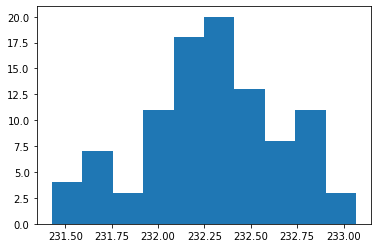

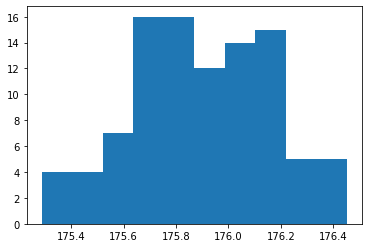

In [0]:
print(int_mat.shape)
int_mat = odom_np['instrinsic_matrix']
print(np.median(odom_np['instrinsic_matrix'], axis = 0))
print(int_mat.shape)
plt.hist(int_mat[:,0,0])
plt.figure()
plt.hist(int_mat[:,1,1])

In [0]:
print(np.array((4,3,2,1))[:,np.newaxis].shape)

(4, 1)


In [0]:
## use pandas
# organize dataframe, with the following headers {"TIMESTAMP", "X", "Y", "agent_id", "class"}
def viz_sequence(
    df: pd.DataFrame, lane_centerlines: Optional[np.ndarray] = None, show: bool = True, smoothen: bool = False
) -> None:

    # Seq data
    time_list = np.sort(np.unique(df["TIMESTAMP"].values))
    city_name = df["CITY_NAME"].values[0]

    if lane_centerlines is None:
        # Get API for Argo Dataset map
        avm = ArgoverseMap()
        seq_lane_bbox = avm.city_halluc_bbox_table[city_name]
        seq_lane_props = avm.city_lane_centerlines_dict[city_name]

    plt.figure(0, figsize=(8, 7))

    x_min = min(df["X"])
    x_max = max(df["X"])
    y_min = min(df["Y"])
    y_max = max(df["Y"])

    if lane_centerlines is None:

        plt.xlim(x_min, x_max)
        plt.ylim(y_min, y_max)

        lane_centerlines = []
        # Get lane centerlines which lie within the range of trajectories
        for lane_id, lane_props in seq_lane_props.items():

            lane_cl = lane_props.centerline

            if (
                np.min(lane_cl[:, 0]) < x_max
                and np.min(lane_cl[:, 1]) < y_max
                and np.max(lane_cl[:, 0]) > x_min
                and np.max(lane_cl[:, 1]) > y_min
            ):
                lane_centerlines.append(lane_cl)

    for lane_cl in lane_centerlines:
        plt.plot(lane_cl[:, 0], lane_cl[:, 1], "--", color="grey", alpha=1, linewidth=1, zorder=0)
    frames = df.groupby("TRACK_ID")

    plt.xlabel("Map X")
    plt.ylabel("Map Y")

    color_dict = {"AGENT": "#d33e4c", "OTHERS": "#d3e8ef", "AV": "#007672"}
    object_type_tracker: Dict[int, int] = defaultdict(int)

    # Plot all the tracks up till current frame
    for group_name, group_data in frames:
        object_type = group_data["OBJECT_TYPE"].values[0]

        cor_x = group_data["X"].values
        cor_y = group_data["Y"].values

        if smoothen:
            polyline = np.column_stack((cor_x, cor_y))
            num_points = cor_x.shape[0] * 3
            smooth_polyline = interpolate_polyline(polyline, num_points)
            cor_x = smooth_polyline[:, 0]
            cor_y = smooth_polyline[:, 1]

        plt.plot(
            cor_x,
            cor_y,
            "-",
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            linewidth=1,
            zorder=_ZORDER[object_type],
        )

        final_x = cor_x[-1]
        final_y = cor_y[-1]

        if object_type == "AGENT":
            marker_type = "o"
            marker_size = 7
        elif object_type == "OTHERS":
            marker_type = "o"
            marker_size = 7
        elif object_type == "AV":
            marker_type = "o"
            marker_size = 7

        plt.plot(
            final_x,
            final_y,
            marker_type,
            color=color_dict[object_type],
            label=object_type if not object_type_tracker[object_type] else "",
            alpha=1,
            markersize=marker_size,
            zorder=_ZORDER[object_type],
        )

        object_type_tracker[object_type] += 1

    red_star = mlines.Line2D([], [], color="red", marker="*", linestyle="None", markersize=7, label="Agent")
    green_circle = mlines.Line2D([], [], color="green", marker="o", linestyle="None", markersize=7, label="Others")
    black_triangle = mlines.Line2D([], [], color="black", marker="^", linestyle="None", markersize=7, label="AV")

    plt.axis("off")
    if show:
        plt.show()

Determining the depth of objects

In [0]:
!python -m depth_from_video_in_the_wild.trajectory_inference_1 \
!  --checkpoint_path=depth_from_video_in_the_wild/odometry_weights/odometry_learned_intrinsics/checkpoint/model-413174 \
!  --odometry_test_set_dir=../../accident_data/reformatting_imgs/reordered_final_outputs_2/training \
!  --output_dir=depth_from_video_in_the_wild/odometry_trajectory_outputs/training \
!  --alsologtostderr
#'/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/accident_data/reformatting_imgs/reordered_final_outputs_2'

/usr/local/lib/python3.6/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

I0109 21:58:53.722306 140367776171904 model_3.py:84] batch_size: 1
I0109 21:58:53.722535 140367776171904 model_3.py:84] beta1: 0.9
I0109 21:58:53.722827 140367776171904 model_3.py:84] boxify: True
I0109 21:58:53.722949 140367776171904 model_3.py:84] data_dir: None
I0109 21:58:53.723008 140367776171904 model_3.py:84] depth_consistency_loss_weight: 0.01
I0109 21:58:53.723056 140367776171904 model_3.py:84] f

In [0]:
odometry_test_set_dir = '../../accident_data/reformatting_imgs/reordered_final_outputs_2/training'
output_dir = 'depth_from_video_in_the_wild/odometry_trajectory_outputs/training'
src_folders = sorted(os.listdir(odometry_test_set_dir))
dest_folders = sorted(os.listdir(output_dir))
dest_folders1 = [dest_folders[i][9:-4] for i in range(len(dest_folders))]
ODOMETRY_SETS = sorted(list(set(src_folders) - set(dest_folders1)))

print(ODOMETRY_SETS)
print(src_folders)
print(dest_folders)

['negative_000742', 'negative_000743', 'negative_000744', 'negative_000745', 'negative_000746', 'negative_000747', 'negative_000748', 'negative_000749', 'negative_000750', 'negative_000751', 'negative_000752', 'negative_000753', 'negative_000754', 'negative_000755', 'negative_000756', 'negative_000757', 'negative_000758', 'negative_000759', 'negative_000760', 'negative_000761', 'negative_000762', 'negative_000763', 'negative_000764', 'negative_000765', 'negative_000766', 'negative_000767', 'negative_000768', 'negative_000769', 'negative_000770', 'negative_000771', 'negative_000772', 'negative_000773', 'negative_000774', 'negative_000775', 'negative_000776', 'negative_000777', 'negative_000778', 'negative_000779', 'negative_000780', 'negative_000781', 'negative_000782', 'negative_000783', 'negative_000784', 'negative_000785', 'negative_000786', 'negative_000787', 'negative_000788', 'negative_000789', 'negative_000790', 'negative_000791', 'negative_000792', 'negative_000793', 'negative_0

In [0]:
!pwd
print(sorted(os.listdir('../../accident_data/reformatting_imgs/reordered_final_outputs_2/training')))
#'DenseDepth/google_distance_code/accident_data/reformatting_imgs/reordered_final_outputs_2'

/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/google_dist_code_1/google-research
['negative_000001', 'negative_000002', 'negative_000003', 'negative_000004', 'negative_000005', 'negative_000006', 'negative_000007', 'negative_000008', 'negative_000009', 'negative_000010', 'negative_000011', 'negative_000012', 'negative_000013', 'negative_000014', 'negative_000015', 'negative_000016', 'negative_000017', 'negative_000018', 'negative_000019', 'negative_000020', 'negative_000021', 'negative_000022', 'negative_000023', 'negative_000024', 'negative_000025', 'negative_000026', 'negative_000027', 'negative_000028', 'negative_000029', 'negative_000030', 'negative_000031', 'negative_000032', 'negative_000033', 'negative_000034', 'negative_000035', 'negative_000036', 'negative_000037', 'negative_000038', 'negative_000039', 'negative_000040', 'negative_000041', 'negative_000042', 'negative_000043', 'negative_000044', 'negative_000045', 'negative_000

In [0]:
## find npy files, see if they are the correct shape
print(os.listdir('./depth_from_video_in_the_wild/odometry_trajectory_outputs'))

cur_path = 'depth_from_video_in_the_wild/odometry_trajectory_outputs/odometry_09-image_2.npz'

odometry_outputs = np.load(cur_path)

['odometry_09-image_2.txt', 'odometry_10-image_2.txt', 'odometry_09-image_2.npz', 'odometry_10-image_2.npz']


In [0]:
## find the destination path
!pwd
print(os.listdir('./'))
dest_path_root = '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/accident_data/reformatting_imgs/reordered_final_outputs_2'


print(os.listdir(dest_path_reform_imgs))
## find path to cropped images

/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/google_dist_code_1/google-research
['.gitignore', '.travis.yml', 'CONTRIBUTING.md', 'LICENSE', 'README.md', '__init__.py', 'compile_protos.sh', 'depth_from_video_in_the_wild', 'image_utils.py', '__pycache__', 'depth_checkpoints', 'lib', 'third_party']
['training', 'testing']


In [0]:
temp1 = ['One', 'Two', 'Three', 'Four']
temp2 = ['One', 'Two']

list(set(temp1) - set(temp2))
print(set(temp1))
print(set(['One', 'Two', 'One']))

print(set(temp2) - set(temp1) )

{'Four', 'Three', 'Two', 'One'}
{'Two', 'One'}
set()


In [0]:
from glob import glob
train_list = sorted(glob(dest_path_root+'/'+'training'+'/*'))
test_list = sorted(glob(dest_path_root+'/'+'testing'+'/*'))

print(sorted(glob(dest_path_root+'/'+'training'+'/*')))
# print(dest)

['/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/accident_data/reformatting_imgs/reordered_final_outputs_2/training/negative_000001', '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/accident_data/reformatting_imgs/reordered_final_outputs_2/training/negative_000002', '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/accident_data/reformatting_imgs/reordered_final_outputs_2/training/negative_000003', '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/accident_data/reformatting_imgs/reordered_final_outputs_2/training/negative_000004', '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/accident_data/reformatting_imgs/reordered_final_outputs_2/training/negative_000005', '/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distan

['rot', 'trans', 'instrinsic_matrix', 'orientation', 'position']
(98, 3, 3)
(98, 3)
(98, 3, 3)
(98, 3, 3)
(98, 3)


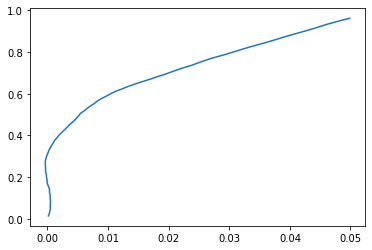

In [0]:
print(list(odometry_outputs.keys()))
print(odometry_outputs['rot'].shape)
print(odometry_outputs['trans'].shape)
print(odometry_outputs['instrinsic_matrix'].shape)
print(odometry_outputs['orientation'].shape)
print(odometry_outputs['position'].shape)
positions = odometry_outputs['position']
plt.plot(positions[:,0],positions[:,2])

In [0]:
def load_images(image_files):
    from skimage.transform import resize
    loaded_images = []
    iter1 = 0

    for file in image_files:
        crop_middle, crop_upper, crop_lower, img_shape = selective_cropping(file)

        if iter1 == 0:
          img_stack_middle, img_stack_upper, img_stack_lower = crop_middle, crop_upper, crop_lower
        elif img_stack_upper.any() != None:
          img_stack_middle, img_stack_upper, img_stack_lower = np.concatenate((img_stack_middle, crop_middle), axis = 0), np.concatenate((img_stack_upper, crop_upper), axis = 0), np.concatenate((img_stack_lower, crop_lower), axis = 0),
        else:
          img_stack_middle = np.concatenate((img_stack_middle, crop_middle), axis = 0)
        iter1+=1


    return img_stack_middle, img_stack_upper, img_stack_lower, img_shape


def crop(img):
    # Perform center cropping, preserving 50% vertically.
    middle_perc = 0.50
    left = 1-middle_perc
    half = left/2
    a = img[int(img.shape[0]*(half)):int(img.shape[0]*(1-half)), :]

    # Resize to match target height while preserving aspect ratio.
    wdt = int((128*a.shape[1]/a.shape[0]))
    x_scaling = float(wdt)/a.shape[1]
    y_scaling = 128.0/a.shape[0]
    b = cv2.resize(a, (wdt, 128))

    # Perform center cropping horizontally.
    remain = b.shape[1] - 416
    # cx /= (b.shape[1]/416)
    c = b[:, int(remain/2):b.shape[1]-int(remain/2)]

    return c

def crop_upper(img):
    # cropping the top
    middle_perc = 0.50
    left = 1-middle_perc
    half = left/2
    a = img[0:int(img.shape[0]*(middle_perc)), :]
    wdt = int((128*a.shape[1]/a.shape[0]))
    x_scaling = float(wdt)/a.shape[1]
    y_scaling = 128.0/a.shape[0]
    b = cv2.resize(a, (wdt, 128))
    remain = b.shape[1] - 416
    c = b[:, int(remain/2):b.shape[1]-int(remain/2)]
    return c

def crop_lower(img):
    # cropping the top
    middle_perc = 0.50
    left = 1-middle_perc
    half = left/2
    a = img[(-1)*int(img.shape[0]*(middle_perc))::, :]
    wdt = int((128*a.shape[1]/a.shape[0]))
    x_scaling = float(wdt)/a.shape[1]
    y_scaling = 128.0/a.shape[0]
    b = cv2.resize(a, (wdt, 128))
    remain = b.shape[1] - 416
    c = b[:, int(remain/2):b.shape[1]-int(remain/2)]
    return c

# random functions
def obtain_keys(lis):
    key_ls = list()
    for k in lis:
        integer = re.split('([0-9]+)', k)[1]
        key_ls.append(int(integer))
    return(key_ls)
  
def obtain_keys1(lis):
    key_ls = list()
    for k in lis:
        integer = re.split('([0-9]+)', k)[3]
        key_ls.append(int(integer))
    return(key_ls)
  
def h(seq):
    return sorted(range(len(seq)), key=seq.__getitem__)
  
def sort_dir(lis):
    key_ls = h(obtain_keys(lis))
    return [lis[i] for i in key_ls]

## Perform cropping and resizing, place into network
def selective_cropping(img):
  x = np.clip(np.asarray(Image.open( img ), dtype=float) / 255, 0, 1)
  cropped = np.expand_dims(crop(x), axis = 0)
  cropped1 = None
  cropped2 = None
  if (np.abs(cropped.shape[1]-128)>30) and (np.abs(cropped.shape[2]-416)>30):
    x_1 = np.zeros((720,1280, 3))
    x_1[0:x.shape[0], 0:x.shape[1], :] = x  
    cropped = np.expand_dims(crop(x_1), axis = 0)
    print("Cropping pattern did not fit, resized.")
    print(img_folders)
  else:
    cropped1 = np.expand_dims(crop_upper(x), axis = 0)[:,:,0:-1,:]
    cropped2 = np.expand_dims(crop_lower(x), axis = 0)[:,:,0:-1,:]
  cropped = cropped[:,:,0:-1,:]
  img_shape = x.shape
  return cropped, cropped1, cropped2, img_shape

In [0]:
# tf.reset_default_graph() 
# train_model = model.Model(data_dir='depth_from_video_in_the_wild/data_example',is_training=True)
# saver  = train_model.saver

# # saver = tf.train.Saver()
sess = tf.Session()
# saver.restore(sess, save_path = 'depth_from_video_in_the_wild/depth_cp_2/model-1000977')

depth_model = model.Model(is_training=False, batch_size = 100)

Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).


Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:
Please use `layer.__call__` method instead.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


Instructions for updating:
Use `tf.cast` instead.


Instructions for updating:
Use `tf.cast` instead.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


In [0]:
import tensorflow as tf
print(tf.__version__)

1.15.0


In [0]:
print(image_stack_middle.shape)
start_time = time.time()
output = depth_model.inference_depth(image_stack_middle, sess)
print(time.time() - start_time)

plt.imshow(output[0,:,:,0])

NameError: ignored

In [0]:
new_output = output[0][:,:,0:(416*2),:]
new_output = np.concatenate((new_output,new_output,new_output,new_output),axis=0)
print(new_output.shape)

NameError: ignored

In [0]:
print(os.listdir('./depth_from_video_in_the_wild/odometry_weights/odometry_learned_intrinsics/checkpoint/'))

## Getting pose from rotation matrix
## http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MARBLE/high/high.htm

# http://homepages.inf.ed.ac.uk/rbf/CVonline/LOCAL_COPIES/MARBLE/high/pose/express.htm

['model-413174.index', 'model-413174.meta', 'model-413174.data-00000-of-00001']


In [0]:
!pwd

/content/gdrive/My Drive/Accident_Anticipation/depth_estimation/DenseDepth/google_distance_code/google_dist_code_1/google-research


In [0]:
!python -m depth_from_video_in_the_wild.trajectory_inference_1 \
!  --checkpoint_path=depth_from_video_in_the_wild/odometry_weights/odometry_learned_intrinsics/checkpoint/model-413174 \
!  --odometry_test_set_dir=depth_from_video_in_the_wild/data_example \
!  --output_dir=depth_from_video_in_the_wild/odometry_trajectory_outputs \
!  --alsologtostderr

# !python -m depth_from_video_in_the_wild.train \
# !  --data_dir=depth_from_video_in_the_wild/data_example \
# !  --checkpoint_dir=depth_from_video_in_the_wild/depth_cp_2 --train_steps=1

/usr/local/lib/python3.6/dist-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

I0108 06:55:14.165225 140580767844224 model_3.py:84] batch_size: 1
I0108 06:55:14.165483 140580767844224 model_3.py:84] beta1: 0.9
I0108 06:55:14.165619 140580767844224 model_3.py:84] boxify: True
I0108 06:55:14.165731 140580767844224 model_3.py:84] data_dir: None
I0108 06:55:14.165832 140580767844224 model_3.py:84] depth_consistency_loss_weight: 0.01
I0108 06:55:14.165955 140580767844224 model_3.py:84] f

In [0]:
## odometry_inference
# 
im_files = sorted(tf.gfile.ListDirectory(image_sequence_dir))
im_files = [
    os.path.join(image_sequence_dir, f)
    for f in im_files
    if 'png' in f and 'seg' not in f
]
num_images = len(im_files)

# Divide the work to NUM_THREADS threads
results = [None] * NUM_THREADS
group_size = int(math.ceil(num_images / NUM_THREADS))
threads = []
for tid in range(NUM_THREADS):
  results[tid] = {}
  group_start = group_size * tid
  group_end = min(group_size * (tid + 1), num_images)
  im_group = im_files[group_start:group_end]
  threads.append(
      threading.Thread(
          target=get_egomotion,
          args=(im_group, results[tid], infer_egomotion)))

def processed_images():
  return sum([len(results[th]) for th in range(NUM_THREADS)])

threads.append(
    threading.Thread(
        target=_logger, args=(num_images, processed_images)))

In [0]:
str1 = ['training', 'testing']
str2 = ['positive','negative']

## three for loops, make outfile


for a1 in str1:
  for a2 in str2:
    
    root_path = '/content/gdrive/My Drive/Accident_Anticipation/Anticipating-Accidents/dataset/videos/frames/'
    dir_list = sort_dir(os.listdir(root_path+a1+'/'+a2+'/'))
    output_root = './outputs/'+a1+'/'+a2+'/'
    
    for a3 in dir_list:
      # Check which files were already created
      existing_list = sort_dir(os.listdir(output_root))
      curr_file = a3 + '.npz'
      
      if (curr_file in existing_list):
        pass
      
      else:
        print(a1, a2,a3)
        start_time = time.time()
        #print(a3)
        args_input = root_path+a1+'/'+a2+'/'+a3+'/*.jpg'
        args_output = output_root+a3+'.npz'
        files_list = glob.glob(args_input)
        start_time = time.time()

        sort_keys = h(obtain_keys1(files_list))
        r_files_list = [files_list[i] for i in sort_keys]
        
        print(r_files_list)

        # Input images
        output_list = load_images( r_files_list )
        inputs = output_list[0]
        x_shape = output_list[1]
        #print(inputs.shape)
        #print(x_shape)
        print('\nLoaded ({0}) images of size {1}.'.format(inputs.shape[0], inputs.shape[1:]))

        # Compute results
        outputs = predict(model, inputs)

        outputs2 = scale_up(2,outputs)
        outputs_final = scale_up_2(x_shape[0],x_shape[1],outputs2)

        #### make code to save npy file in specified directory
        np.savez(args_output , distance=outputs_final)

        print('Saved file :' + str(args_output))

        print(time.time() - start_time)

print(a1)

testing
